# Diabetes risk factors
(Mathematical Statistics Homework Project)

**Viktória Nemkin (M8GXSS)**

I am interested in medical research, so I have chosen the [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) from Kaggle as the topic of my homework project. The goal of this dataset is to predict whether someone will develop diabetes, based on key indicators of the disease.

## Input data

The dataset is anonymised and contains the following data about 100,000 individuals:

- **Age**: Ranges from 0-80, diabetes is more common amongst older adults.
- **Gender**: Can also have an impact on a person's susceptibility.
- **Body Mass Index (BMI)**: Higher BMI values are linked to higher diabetes risk.
- **Hypertension**: Presistently elevated blood pressure in the arteries, linked to heart disease.
- **Heart disease**: Associated with a risk of developing diabetes.
- **Smoking history**: Considered as a risk factor, can worsen the complications of diabetes.
- **HbA1c level**: Hemoglobin A1c, measures blood sugar level over the past 2-3 months. Over 6.5% indicates diabetes.
- **Blood glucose level**: Key indicator of diabetes.
- **Diabetes**: Target value.

These are some of the key indicators of diabetes, along with demographic data, which could be used to determine risk factors for developing diabetes.

## Tools

I used Python, the `numpy` and `pandas` libraries for manipulation of the dataset, `matplotlib` for plotting and `scikit-learn` for the various statistical analysis and evaluation tools it offers.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data cleaning and sanity checks

The first step in working with data is making sure it is not flawed. There
is no single method that we can follow and guarantee no issues persist, but essentially
we need to be careful and thourough and make sure nothing weird is happening in the dataset.

First, I read in the dataset from the csv file.

In [191]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


I like check the value ranges for the data and make sure, that the columns are correctly typed:

In [151]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

We can use the describe method to check the value ranges of the columns:

In [155]:
df.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


This shows, that `gender` and `smoking_history` are actually categorical columns (they have a few unique values), while `hypertension`, `heart_disease`, and `diabetes` are meant to be boolean, and finally `age` should be an integer.

In [160]:
df['age'] = df['age'].astype(int)
df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)
df['diabetes'] = df['diabetes'].astype(bool)

df.dtypes

gender                 category
age                       int32
hypertension               bool
heart_disease              bool
smoking_history        category
bmi                     float64
HbA1c_level             float64
blood_glucose_level       int64
diabetes                   bool
dtype: object

Let's check our categorical values:

In [164]:
columns = df.select_dtypes(include='category').columns.tolist()

for column in columns:
    values = sorted(list(df[column].unique()))
    print(column)
    print(values)
    print()

gender
['Female', 'Male', 'Other']

smoking_history
['current', 'ever', 'former', 'never', 'no_info', 'not_current']



I would like to fix the inconsistent values in `smoking_history`:

In [165]:
df['smoking_history'] = df['smoking_history'].replace({'No Info': 'no_info', 'not current': 'not_current'})

columns = df.select_dtypes(include='category').columns.tolist()

for column in columns:
    values = sorted(list(df[column].unique()))
    print(column)
    print(values)
    print()

gender
['Female', 'Male', 'Other']

smoking_history
['current', 'ever', 'former', 'never', 'no_info', 'not_current']



### Analising the column values and their distribution

When our data comes from a third party, and we have not collected it ourselves, it is a good idea to check for any inconsistencies in the values.

First, I checked that no values were missing.

In [124]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

If there were missing values, we could drop them with `df.dropna(inplace=True)`, but it is not needed.

#### BMI

The first weirdness I noticed was with BMI.

Let us plot the values of BMI in a histogram:

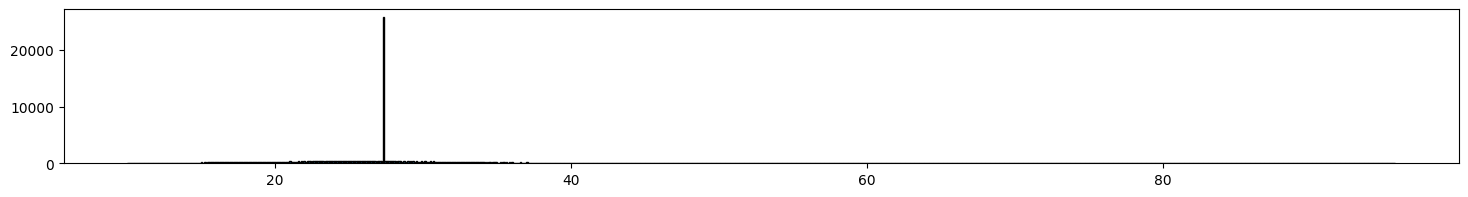

In [192]:
values = df['bmi']
counts, bins, _ = plt.hist(values, bins=1000, edgecolor='black')

plt.gcf().set_size_inches(18, 2)
plt.show()

That doesn't look good. I kept increasing the bins, but that singular peak will not disappear. Let's try logarithmic scale, so we can at least see something:

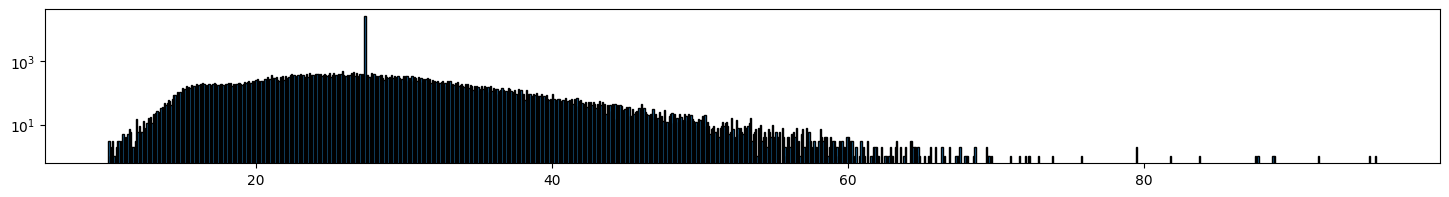

In [193]:
values = df['bmi']
counts, bins, _ = plt.hist(values, bins=1000, edgecolor='black')
plt.yscale('log')
plt.gcf().set_size_inches(18, 2)
plt.show()

Is that a single value of BMI? Let's count the most common values:

In [120]:
max_count_bin = np.argmax(counts)
max_count = counts[max_count_bin]
max_bin_range = (bins[max_count_bin], bins[max_count_bin + 1])

max_bin_range

unique_values, counts = np.unique(values, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
sorted_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

top_10_values = sorted_values[:10]
top_10_counts = sorted_counts[:10]

print(top_10_values)
print(top_10_counts)


[27.32 23.   27.12 27.8  24.96 22.4  25.   25.6  26.7  24.5 ]
[25495   103   101   100   100    99    99    98    94    94]


Yes, for some reason, we have over $\frac{1}{4}$ entries of the dataset with the exact BMI of 27.32. Let's look at these:

In [190]:
weird_entries = df[df['bmi'] == 27.32]

weird_entries.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
1,Female,54,False,False,no_info,27.32,6.6,80,False
2,Male,28,False,False,never,27.32,5.7,158,False
5,Female,20,False,False,never,27.32,6.6,85,False
9,Female,32,False,False,never,27.32,5.0,100,False
10,Female,53,False,False,never,27.32,6.1,85,False
14,Female,76,False,False,no_info,27.32,5.0,160,False
15,Male,78,False,False,no_info,27.32,6.6,126,False
18,Female,42,False,False,no_info,27.32,5.7,80,False
26,Male,67,False,True,not_current,27.32,6.5,200,True
38,Male,50,True,False,current,27.32,5.7,260,True


These all seem like real entries, not duplicates of the same entry. My best guess for what happened, is that when the BMI was missing, they put down the mean of the rest of the dataset, which is exactly `27.32`.

In [174]:
df[df['bmi'] != 27.32]['bmi'].mean()

27.321029595329176

In a real life scenario, I would clearify this with the person who gave me the data, however for this homework project, I will assume that when a person looks average weight, they may not bother measuring their BMI, so the average is probably a good approximation.

I will accept this and continue working on the other values.

### Age

Next issue is with the age.

Let's plot the values:

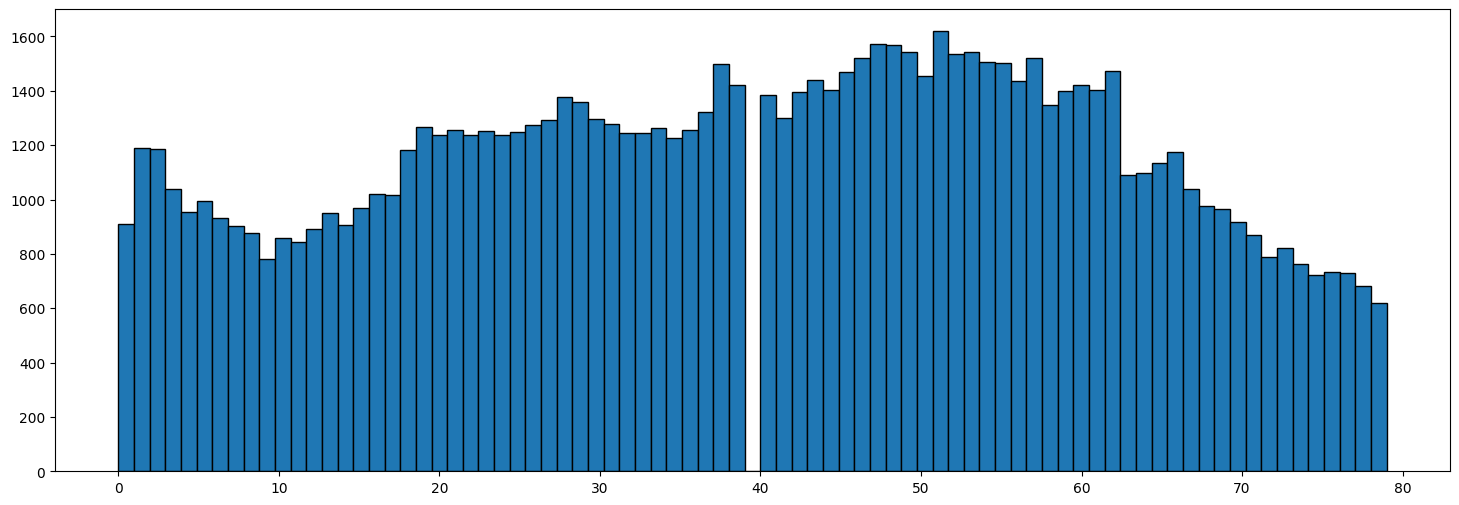

In [179]:
values = df['age']
counts, bins, _ = plt.hist(values, bins=81, edgecolor='black')

plt.gcf().set_size_inches(18, 6)
plt.show()

We have a lot of people aged `80`. It looks like older people are overrepresented in this data and probably not all of them are exactly `80`, they just cut off the age to fit into a `[0,80]` interval.

In [177]:
df[df['age']==80]['age'].count()

5621

In this case, I choose to remove these values, because I feel like this could cause some skewing.

In [178]:
df = df[df['age'] < 80]

### Gender

Let's plot the values:

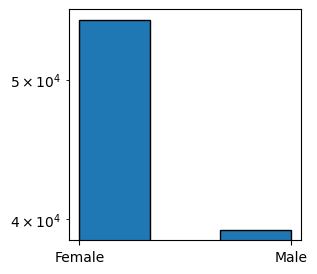

In [189]:
values = df['gender']
counts, bins, _ = plt.hist(values, bins=3, edgecolor='black')
plt.yscale('log')
plt.gcf().set_size_inches(3, 3)
plt.show()

The category Other can mean many things. For medical research, we are concerned about the biological sex of the participants, so I will remove these entries too.

In [188]:
df = df[df['gender'] != 'Other']

## Understanding our data

We can now explore our clean dataset!

First, we can look at the first few rows.

In [125]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,False,True,never,25.19,6.6,140,False
1,Female,54,False,False,no_info,27.32,6.6,80,False
2,Male,28,False,False,never,27.32,5.7,158,False
3,Female,36,False,False,current,23.45,5.0,155,False
4,Male,76,True,True,current,20.14,4.8,155,False


The numerical values can be checked with `df.describe()`.

It looks like the age parameter is relative evenly distributed.

The average BMI falls into the overweight category, with extremes on both ends (BMI of 10 and 97). We should keep this in mind for later, as it could improve our detection to drop these outliers.

Although it is not explicitly stated, blood sugar levels are likely measured after fasting, for which 4.4 - 5.5 is a normal range, 5.6 - 6.9 is elevated and 7.0 and above is high.

## Multivariate linear regression

In [130]:
df_encoded = pd.get_dummies(df)
X = df_encoded.drop('diabetes', axis=1)
X.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_no_info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not_current
0,80,False,True,25.19,6.6,140,True,False,False,False,False,False,False,True,False
1,54,False,False,27.32,6.6,80,True,False,False,True,False,False,False,False,False
2,28,False,False,27.32,5.7,158,False,True,False,False,False,False,False,True,False
3,36,False,False,23.45,5.0,155,True,False,False,False,True,False,False,False,False
4,76,True,True,20.14,4.8,155,False,True,False,False,True,False,False,False,False


In [131]:
y = df_encoded['diabetes']
y.head()

0    False
1    False
2    False
3    False
4    False
Name: diabetes, dtype: bool

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [133]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.051180377272048494


In [134]:
# Display the model's coefficients and intercept
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})
intercept = pd.DataFrame({'Variable': ['Intercept'], 'Coefficient': model.intercept_})

print("Coefficients:")
print(coefficients)
print("\nIntercept:")
print(intercept)

Coefficients:
                       Variable  Coefficient
0                           age     0.001336
1                  hypertension     0.092471
2                 heart_disease     0.118214
3                           bmi     0.004055
4                   HbA1c_level     0.081449
5           blood_glucose_level     0.002275
6                 gender_Female     0.011399
7                   gender_Male     0.024079
8                  gender_Other    -0.035478
9       smoking_history_no_info    -0.011962
10      smoking_history_current    -0.001451
11         smoking_history_ever    -0.003983
12       smoking_history_former     0.015201
13        smoking_history_never    -0.002184
14  smoking_history_not_current     0.004379

Intercept:
    Variable  Coefficient
0  Intercept    -0.870916


Forrás: https://www.geeksforgeeks.org/multiple-linear-regression-with-scikit-learn/

In [135]:
correlation_matrix = df.corr()

print("Correlation Matrix:")
print(correlation_matrix)


ValueError: could not convert string to float: 'never'